# Doing this from scratch

### TODO:
* Add training data from multiple theta angles
* Reproject inference depth images back to point clouds
* Add non-return mask
* Account for platform motion

In [1]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time
import cv2

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 20*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh


from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2024-03-11 14:30:14.013662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 14:30:14.105203: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 14:30:14.437156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-11 14:30:14.437209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-11 14:30:15.202888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 14:30:15.203766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-11 14:30:15.204051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-11 14:30:15.204266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [15]:
#load raw point cloud data from Newer College Dataset

#NEWER COLLEGE
# idx = 800 
# fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
# pc1 = np.load(fn1)
# pc1 = np.flip(pc1, axis = 0)#flip to maintain CCW convention

# #KITTI-CARLA
# town = 'Town02'
# idx = 0
# s1_fn = '/home/derm/KITTICARLA/dataset/' + town + '/generated/frames/frame_%04d.ply' %(idx)
# dat1 = trimesh.load(s1_fn)
# pc1 = dat1.vertices
# pc1 = pc1[:140_224]
# noise_scale = 0.02 #need to add some noise or numerics can cause VICET and NDT to get stuck
# pc1 += noise_scale*np.random.randn(np.shape(pc1)[0],3)

#TODO: trim synthetic data to [0,2pi] theta

# # synthetic LIDAR data (VICET paper)
# fn1 = "raw_frame_1.npy"
# pc1 = np.load(fn1)

# fn1 = "/home/derm/ASAR/v3/point_cloud_rectification/sample_data/test1/raw_frame_1.npy"
fn1 = "gazebo_scene/scan2.npy"
pc1 = np.load(fn1)
#remove inf values
pc1[pc1[:,0]>100] = 0
pc1[pc1[:,0]<-100] = 0
# noise_scale = 0.02 #need to add some noise or numerics can cause VICET and NDT to get stuck
# pc1 += noise_scale*np.random.randn(np.shape(pc1)[0],3)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]


# #TEST--- add yaw to raw rotation to raw data
# theta = 0.5 #2*np.random.randn()
# yaw_rotm = R.from_euler('xyz', [0,0,theta]).as_matrix()
# pc1 = pc1 @ yaw_rotm
# #-------------------------------------------

## purple -> green
color = 255*np.linspace(0,1,len(pc1)) 
# color = pc1_spherical[:,0] * 4
# print(color)

cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(pc1, c=cname,  r = 3.5, alpha =0.5))
print(len(pc1) / 128)

# test = pc1[::64]
# # # test = test[::64]
# disp.append(Points(test, c='red',r = 5))

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

1158.0


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Convert Point Cloud to Depth Image


In [16]:
pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi] --> theta = azimuth, phi = elevation
print(np.shape(pc1_spherical))

depth_image = np.zeros([64, len(pc1_spherical)//64])
# depth_image = np.zeros([128, len(pc1_spherical)//128])
# print(np.shape(depth_image))

# #nope?
# #sort pc1_spherical by azim and elevation angles
# pc1_spherical = np.reshape(pc1_spherical, [1024,64,-1])[:,:,0].T
# print(np.shape(pc1_spherical))

#set points of radius zero (i.e. non returns) to large values
depth_image = pc1_spherical.copy()
non_return_idx = np.argwhere(depth_image == 0)
# print(non_return_idx)
depth_image[non_return_idx[:,0], non_return_idx[:,1]] = 10

(148224, 3)


In [17]:
pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
# pc1_spherical = LC.c2s(LC,new_point_cloud_cart).numpy() #[r, theta, phi] 
pcs = np.reshape(pc1_spherical, [-1,64,3])
# pcs = np.reshape(pc1_spherical, [-1,128,3])
print(np.shape(pcs))
pcs = np.flip(pcs, axis = 1)

# pcs = pcs[np.argsort(pcs, axis = 1)[:,0,0]]
# print(np.shape(pcs))

(2316, 64, 3)


(64, 2316)


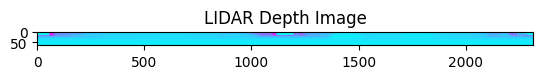

In [18]:
fig, ax = p.subplots()
ax.set_title("LIDAR Depth Image")
# data = pcs[650:850,:,0].T
data = pcs[:,:,0].T
# data = (data)%10 #add zebra stripes to make it easier to visualize depth
p.imshow(data, cmap = "cool", norm='linear')
print(np.shape(data))

# Reproject 2D Depth image back to 3D point cloud using same convention

In [19]:
#Get LiDAR Intrinsics
#Simulated LIDAR Sensor -- (look for <min_angle> in velodyne.world file in ROS package)
phimin = -0.53529248 #rad
phimax = 0.18622663 #rad

new_point_cloud_spherical = np.zeros([np.shape(pcs)[0]*np.shape(pcs)[1],3])
pc1_spherical = new_point_cloud_spherical

count = 0
for w in range(np.shape(pcs)[0]):
    for h in range(np.shape(pcs)[1]):
        new_point_cloud_spherical[count,0] = pcs[w,h,0] #radius
        new_point_cloud_spherical[count,1] = 2*np.pi*(w/np.shape(pcs)[0]) #theta
        new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(pcs)[1]) #phi
        count+= 1

new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
print(np.shape(new_point_cloud_cart))
print(new_point_cloud_cart)

#shape image to have same angular field of view in width and height
vert_fov = np.rad2deg(phimax-phimin)
print(vert_fov)
vert_fov/360
print((vert_fov/360)*np.shape(pcs)[0])

(148224, 3)
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 ...
 [ 3.34713717 -0.00908063 -1.83495553]
 [ 3.25741422 -0.00883721 -1.83382717]
 [ 3.15922919 -0.00857084 -1.82575801]]
41.33999984103539
265.9539989773277


In [20]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

disp.append(Points(new_point_cloud_cart, c='red',  r = 3.5, alpha =0.5))
disp.append(Points(pc1, c = 'blue', r = 3.5, alpha = 0.5))

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Load Gazebo Point Clouds and Convert to Image Training Data

##### NOTE: be careful with syncing pose and image indices!

7
(24, 7)


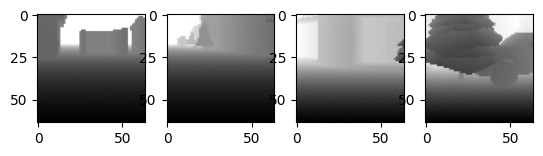

In [57]:
n_images = 17 #18
n_rots = 3 #1 #number of side by side frames to add in
#achieve roughly same horizonal and vertical fov
vert_fov = np.rad2deg(phimax-phimin)
image_width = int((vert_fov/360)*np.shape(pcs)[0])
print(image_width)
# images = np.zeros([n_images, 64, image_width, 1])
images = np.zeros([n_images*n_rots, 64, 64, 1]) #no upscaling
# images = np.zeros([n_images, 128, 128, 1]) #test upscaling
# images = np.zeros([n_images, 256, 256, 1]) #test upscaling
poses = np.zeros([n_images*n_rots,4,4])

gtfn = "gazebo_scene/ground_truth.npy"
sensor_pose = np.load(gtfn)
# print(sensor_pose)
print(np.shape(sensor_pose))

# fig, ax = p.subplots(n_images*n_rots)

for i in range(n_images):
    for j in range(n_rots):
        #load point cloud file
        pcfn = "gazebo_scene/scan" + str(i+2) + ".npy"
        pc = np.load(pcfn)
        #TODO: mask inf values (instead of cap)
        #remove inf values
        pc[pc[:,0]>100] = 64 #0
        pc[pc[:,0]<-100] = 64 #0

        #convert to image array
        pc_spherical = LC.c2s(LC,pc).numpy() #[r, theta, phi]
        pcs = np.reshape(pc_spherical, [-1,64,3])
        pcs = np.flip(pcs, axis = 1) #flip vertical
        pcs = np.flip(pcs, axis = 0) #flip horizontal

        #TODO: resize image to 64x64
        image_width = int((vert_fov/360)*np.shape(pcs)[0])
    #     print(image_width)
#         pcs = pcs[0:image_width,:,0].T #just take from 12:00 to ~2:00
    #     pcs = pcs[2*image_width:3*image_width,:,0].T #try different angle
        pcs = pcs[j*image_width:(j+1)*image_width,:,0].T #try different angle
        pcs = cv2.resize(pcs, (64, 64))
    #     pcs = cv2.resize(pcs, (128, 128), interpolation = cv2.INTER_LINEAR) #test upscaling
    #     pcs = cv2.resize(pcs, (256, 256), interpolation = cv2.INTER_CUBIC) #test upscaling
#         print((j+(i*n_rots)))
        images[j+(i*n_rots),:,:,0] = pcs

        #get sensor transformation matrix
        rotm = np.eye(4)
#         rotm[0,3] = sensor_pose[i+1,0] #x
#         rotm[1,3] = sensor_pose[i+1,1] #y
#         rotm[2,3] = sensor_pose[i+1,2] #z
        #test
        rotm[2,3] = sensor_pose[i+1,0]
        rotm[1,3] = sensor_pose[i+1,1] 
        rotm[0,3] = sensor_pose[i+1,2] 
        rotm[:3,:3] = R.from_quat(sensor_pose[i+1,3:]).as_matrix() 
        
        #debug
#         rotm[:3,:3] = np.eye(3)

#         #old
#         #account for image crop in rotation -------------------
#         #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
#         sensor_elevation_zero_rotm = R.from_euler('xyz', [0,-(phimin+phimax)/2,0]).as_matrix()
#         rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm

#     #     crop_angle = -(phimax-phimin)/2 #12 to 2
# #         crop_angle = -(phimax-phimin)/2 - 2*(phimax-phimin)
#         crop_angle = -(phimax-phimin)/2 - j*(phimax-phimin)
#         rotm_crop = R.from_euler('xyz', [0,0,crop_angle]).as_matrix()
#         rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
#         #------------------------------------------------------

        #test -- I THINK this works better when n_rots > 1 
#         account for image crop in rotation -------------------
    #     crop_angle = -(phimax-phimin)/2 #12 to 2
#         crop_angle = -(phimax-phimin)/2 - 2*(phimax-phimin)
        crop_angle = -(phimax-phimin)/2 - j*(phimax-phimin)
#         crop_angle = (phimax-phimin)/2 + j*(phimax-phimin)#test

#         rotm_crop = R.from_euler('xyz', [0,0,crop_angle]).as_matrix() #with gazebo convention (incompatible)
        rotm_crop = R.from_euler('xyz', [crop_angle,0,0]).as_matrix() #using NeRF c2w() convention
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

        #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
        sensor_elevation_zero_rotm = R.from_euler('xyz', [0,(phimin+phimax)/2,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
#         ------------------------------------------------------

        #nope!
        #reorient frames to face towards + x (like in Gazebo but does not work here) ~~~~~~~~~~
#         rotm[:3,:3] = rotm[:3,:3] @ np.array([[0,0,-1],
#                                               [-1,0,0],
#                                               [0,1,0]])
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        ###old
        #flip x and z axis
#         rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 
        #translate all frames above xy plane
#         rotm[2,-1] += 30
        #scale translations
#         rotm[:3,-1] *= 0.1

        #new
        rotm[0:3,2] *= -1 # flip the y and z axis
        rotm[0:3,1] *= -1
        rotm = rotm[[1,0,2,3],:]
        rotm[2,:] *= -1 # flip whole world upside down

        poses[j+(i*n_rots)] = rotm
#         ax[j+(i*n_rots)].imshow(images[j+(i*n_rots),:,:,0], cmap = "gray")#, norm='linear')    

# fig, ax = p.subplots()
# ax.imshow(images[-1,:,:,0], cmap = "gray", norm='log')

#debug
fig, ax = p.subplots(1,4)
ax[0].imshow(images[-4,:,:,0], cmap = "gray", norm='log')
ax[1].imshow(images[-3,:,:,0], cmap = "gray", norm='log')
ax[2].imshow(images[-2,:,:,0], cmap = "gray", norm='log')
ax[3].imshow(images[-1,:,:,0], cmap = "gray", norm='log')

## TODO 3/9 
Looks like the lidar coordiate system I was using is incompatible with c2w() system used in NeRF  

--I need to change my poses to point down at the focal point, with -z being the forward look direction

In [61]:
print(np.shape(poses))

(50, 4, 4)


In [59]:
#debug coordinate system in <poses>
#vedo
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True)
disp=[]
# disp.append(Points(poses[:,:3,-1], c = "#CB2314"))
#forward view direction (-z in NeRF c2w convention)
headings = poses[:,:3,:3] @ np.array([0,0,-1])
disp.append(Arrows(poses[:,:3,-1], poses[:,:3,-1] + headings[:,:3], c = "yellow"))
#x
headings = poses[:,:3,:3] @ np.array([1,0,0])
disp.append(Arrows(poses[:,:3,-1], poses[:,:3,-1] + headings[:,:3], c = "red"))
#y
headings = poses[:,:3,:3] @ np.array([0,1,0])
disp.append(Arrows(poses[:,:3,-1], poses[:,:3,-1] + headings[:,:3], c = "green"))
#z
headings = poses[:,:3,:3] @ np.array([0,0,1])
disp.append(Arrows(poses[:,:3,-1], poses[:,:3,-1] + headings[:,:3], c = "blue"))
disp.append(Points(np.array([[0,0,0]]), c = 'black'))


plt.show(disp, "camera poses")
ViewInteractiveWidget(plt.window)

print(np.shape(poses))

##mpl
# from mpl_toolkits.mplot3d import axes3d
# from matplotlib import cm
# # %matplotlib notebook

# # print(poses[0])
# ax = p.figure().add_subplot(projection='3d')
# view_size = 25 #5
# ax.set_xlim([-view_size,view_size])
# ax.set_ylim([-view_size,view_size])
# ax.set_zlim([-view_size,view_size])
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# X, Y, Z = axes3d.get_test_data(0.05)
# # ax.contour(X, Y, Z, cmap=cm.coolwarm)  # Plot contour curves

# ax.scatter3D(0,0,0, color='purple')
# camera_centers = ax.scatter3D(poses[:,0,-1],poses[:,1,-1],poses[:,2,-1])
# headings = poses[:,:3,:3] @ np.array([0,0,-1])
# ax.quiver(poses[:,0,-1],poses[:,1,-1],poses[:,2,-1], headings[:,0], headings[:,1], headings[:,2], color = 'yellow', alpha = 0.5)

# headings = poses[:,:3,:3] @ np.array([1,0,0])
# ax.quiver(poses[:,0,-1],poses[:,1,-1],poses[:,2,-1], headings[:,0], headings[:,1], headings[:,2], color = 'red')
# headings = poses[:,:3,:3] @ np.array([0,1,0])
# ax.quiver(poses[:,0,-1],poses[:,1,-1],poses[:,2,-1], headings[:,0], headings[:,1], headings[:,2], color = 'green')
# headings = poses[:,:3,:3] @ np.array([0,0,1]) 
# ax.quiver(poses[:,0,-1],poses[:,1,-1],poses[:,2,-1], headings[:,0], headings[:,1], headings[:,2], color = 'blue')

# p.show()

(51, 4, 4)


In [60]:
#Get LiDAR Intrinsics
#Simulated LIDAR Sensor -- (look for <min_angle> in velodyne.world file in ROS package)
phimin = -0.53529248 #rad
phimax = 0.18622663 #rad
#focal length (in pixels) = Image Size / (2 tan(FOV/2)) #needs to be array!
focal = np.array(np.shape(images)[1]/(2*np.tan((phimax-phimin)/2))) #default image size
# focal = np.array(128/(2*np.tan((phimax-phimin)/2))) #upscaling to 128x128??
H, W = images.shape[1:3]
print(focal, H, W)

images = images.astype(np.float32)
poses = poses.astype(np.float32)

# test on one only
testimg, testpose = images[(n_images*n_rots)-1], poses[(n_images*n_rots)-1]
images = images[:((n_images*n_rots)-1),...,:3]
poses = poses[:((n_images*n_rots)-1)]

# #90/10 split
# cutoff = (n_images*9)//10
# print(cutoff)
# testimg, testpose = images[cutoff:], poses[cutoff:]
# images = images[:cutoff,...,:3]
# poses = poses[:cutoff]

84.81983003899697 64 64


# Train Vanilla TinyNeRF on depth image data 

In [62]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6 #6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256): #8,256
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
#     outputs = dense(4, act=None)(outputs)
#     outputs = dense(2, act=None)(outputs) #"rgb" (single channel) + depth map
    outputs = dense(1, act=None)(outputs) #test

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d


def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=True):

    def batchify(fn, chunk=1024*32): #1024*32
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
#     print("pts",np.shape(pts))
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
#     raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
#     raw = tf.reshape(raw, list(pts.shape[:-1]) + [2]) #two channel (old)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [1]) #depth only (new)

#     print(tf.shape(raw))
    
    # Compute opacities and colors
    #was this
#     sigma_a = tf.nn.relu(raw[...,3])
#     rgb = tf.math.sigmoid(raw[...,:3]) 
#     sigma_a = tf.nn.relu(raw[...,1]) #for depth only (old?)
#     rgb = tf.math.sigmoid(raw[...,0])[:,:,:,None] 
    sigma_a = tf.nn.relu(raw[...,0]) #test only looking at sigma
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
#     rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    rgb_map = tf.reduce_sum(weights * z_vals, -1) #test
    acc_map = tf.reduce_sum(weights, -1)

#     return rgb_map, depth_map, acc_map
    return depth_map, acc_map

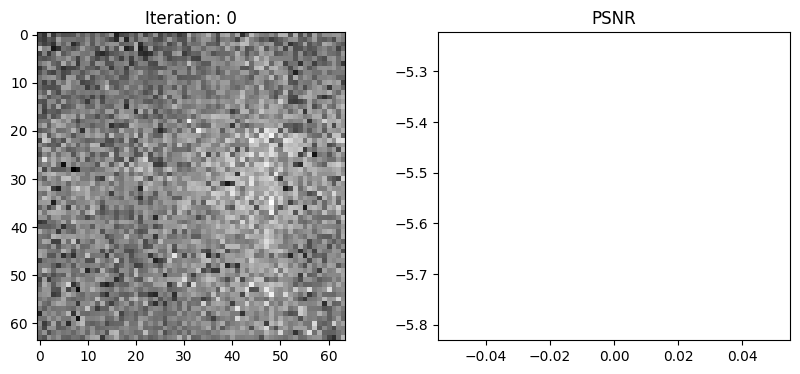

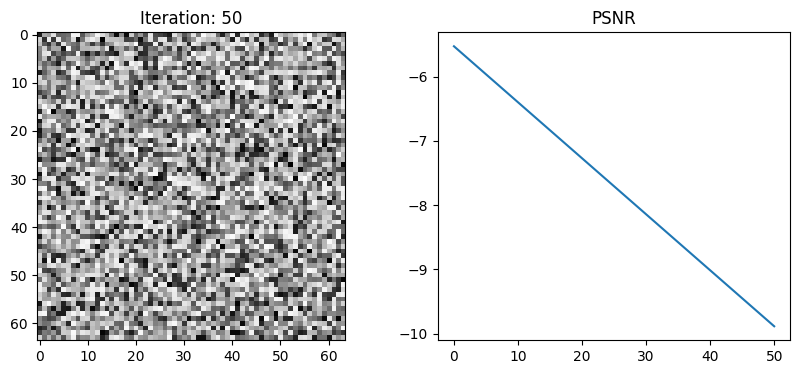

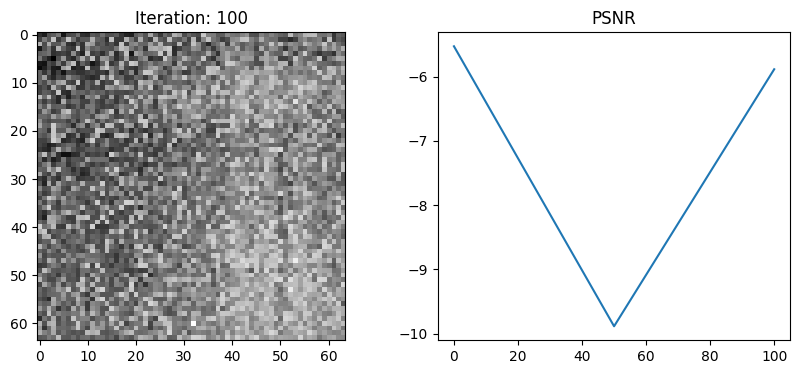

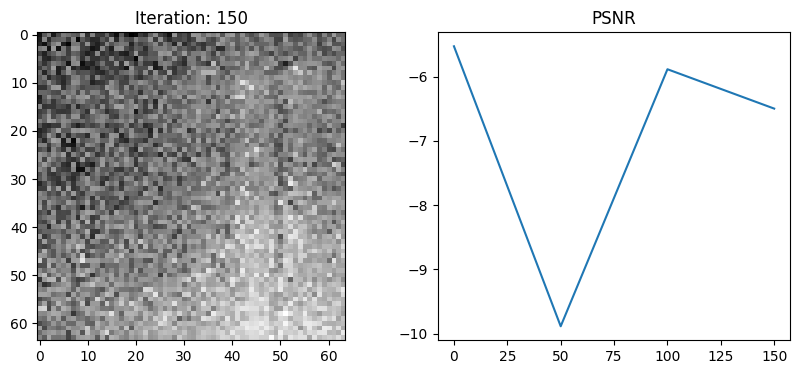

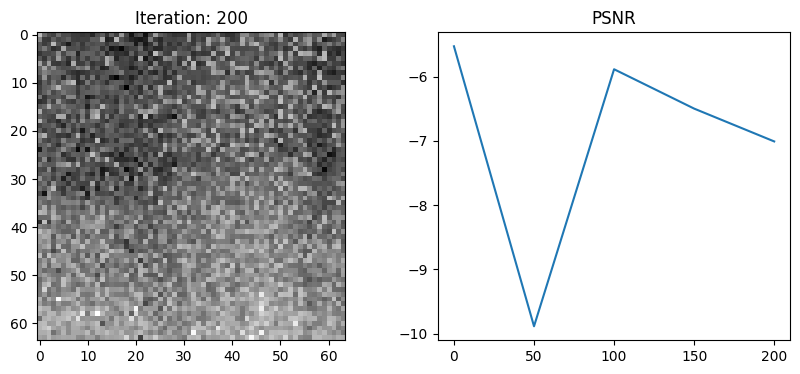

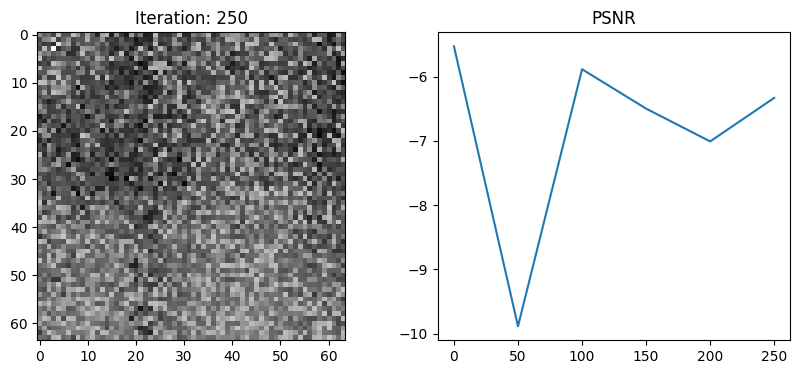

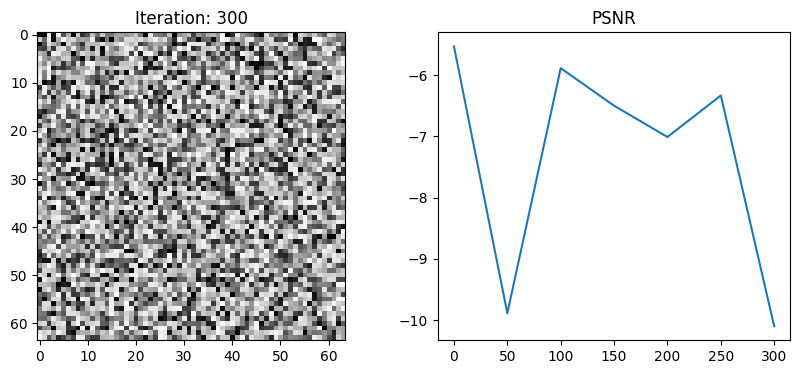

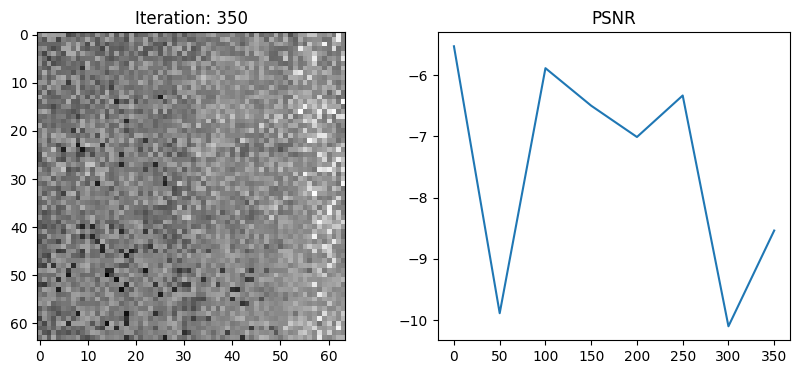

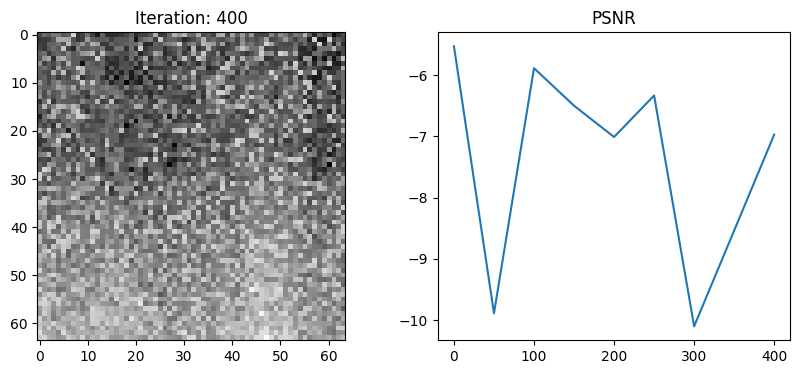

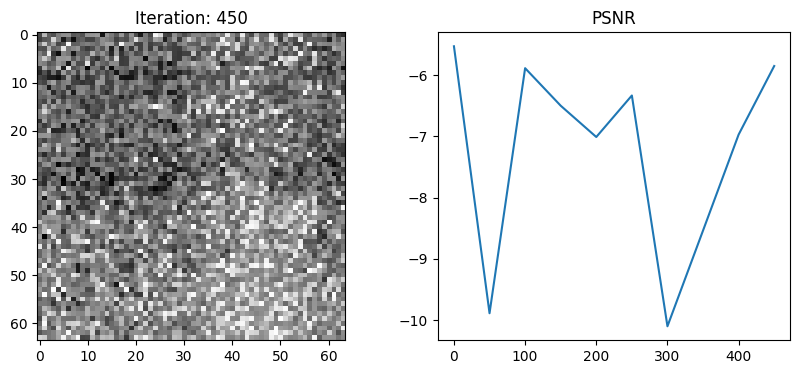

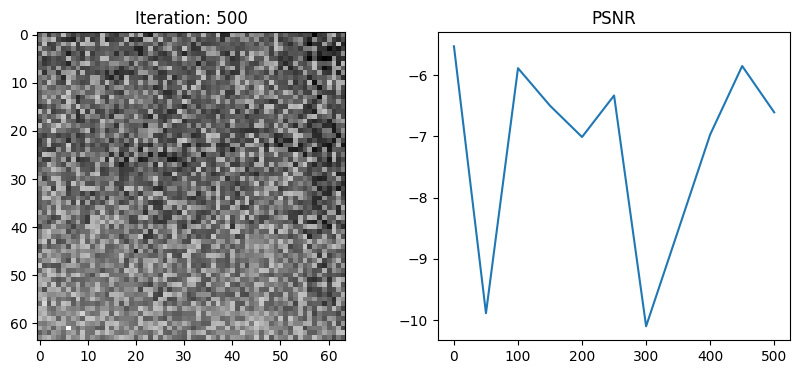

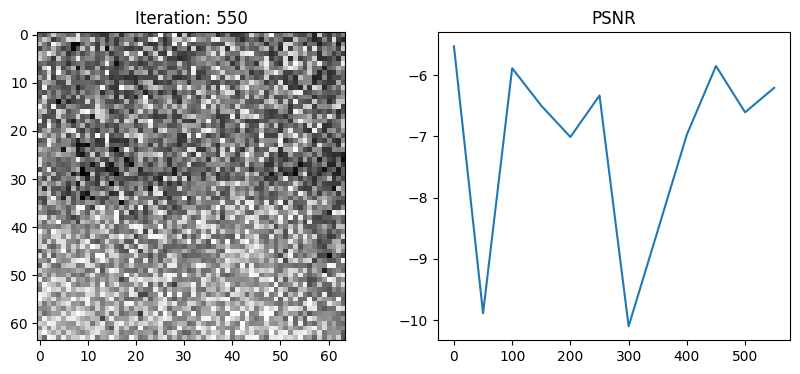

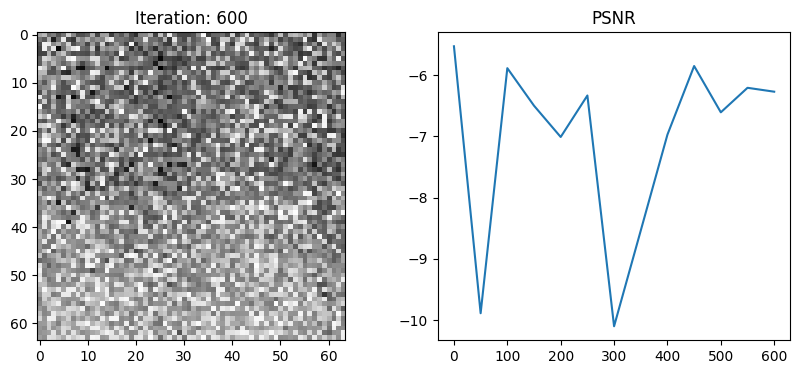

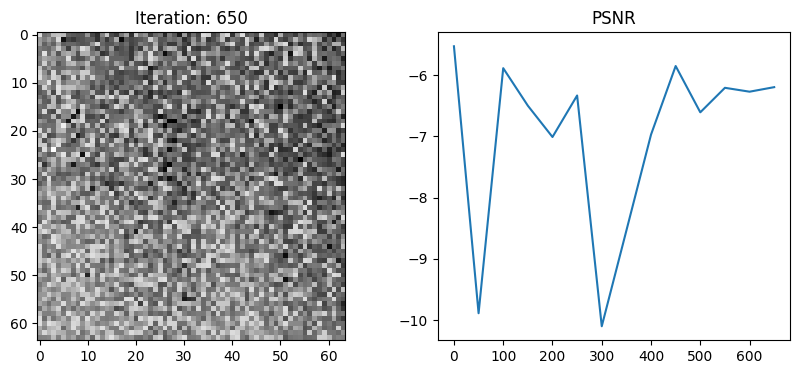

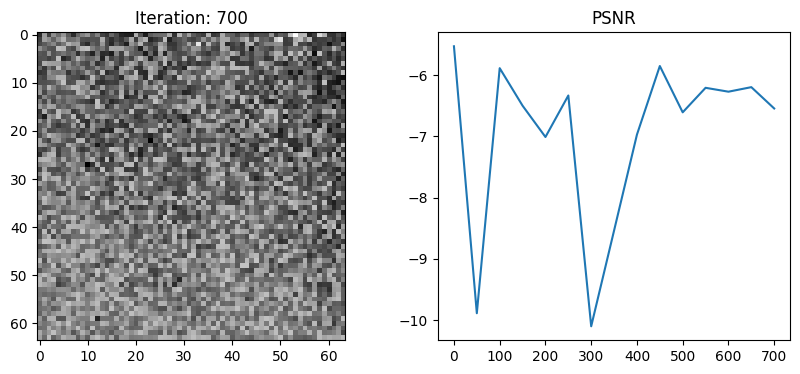

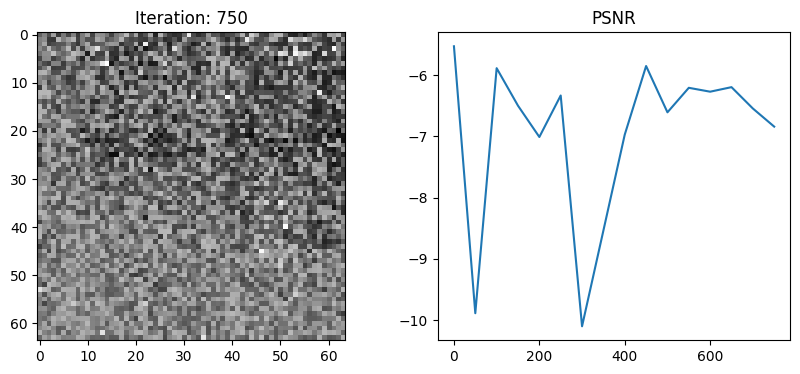

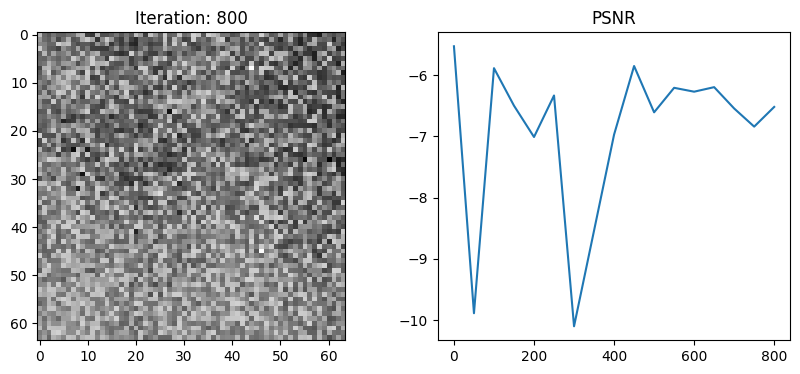

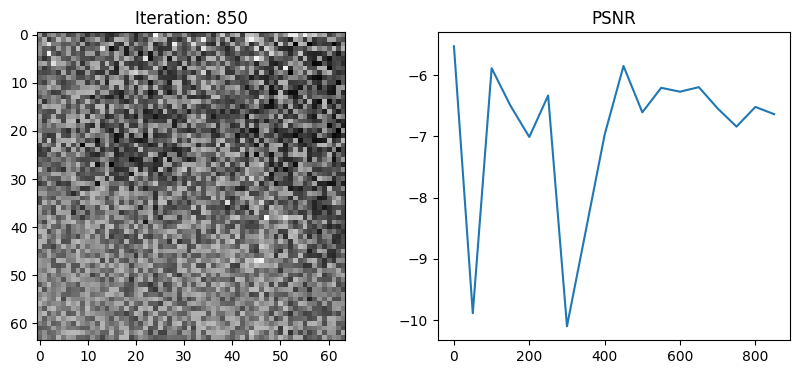


KeyboardInterrupt



In [63]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4) #default tiny-NeRF
# optimizer = tf.keras.optimizers.Adam(1e-3) #test-- let's try and overfit
# optimizer = tf.keras.optimizers.Adam(5e-5)

N_samples = 64 #64 #decrease as needed for VRAM
N_iters = 2500
psnrs = []
iternums = []
i_plot = 50

import time
t = time.time()
for i in range(N_iters+1):
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    
    with tf.GradientTape() as tape:
        #just calculate loss via comparing depth output vs target (should also be depth!)
        depth, acc = render_rays(model, rays_o, rays_d, near=1., far=128., N_samples=N_samples, rand=True)
        depth = depth[:,:,None]
        #default loss from TinyNERF
        loss = tf.reduce_mean(tf.square(depth - target)) 
        #TEST--- weigh error on far away points less heavily
#         loss = tf.reduce_mean(tf.square((depth - target)/target))
#         loss = tf.reduce_mean(tf.square((depth - target))/target)
        #-------------------------------------------------------
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        t = time.time()
        sampl = int(np.random.uniform(low=0, high=len(testpose)-1))        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose) #constant validation image
#         rays_o, rays_d = get_rays(H, W, focal, testpose[sampl]) #90/10 split
        depth, acc = render_rays(model, rays_o, rays_d, near=1., far=128., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(depth[:,:,None] - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(121)
        p.imshow(depth,cmap = "gray", norm='log')
        p.title(f'Iteration: {i}')
        p.subplot(122)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        p.show()
print('Done')

In [47]:
# print(np.shape(depth[:,:,None]))
# print(np.shape(target))

# print(depth)
# print(target)

# p.figure(figsize=(10,4))
# p.subplot(121)
# p.imshow(depth,cmap = "gray", norm='linear')

# Project inference depth image back to 3D point cloud

In [65]:
# Render the holdout view for logging
look_at = 15

rays_o, rays_d = get_rays(H, W, focal, poses[look_at])
# rays_o, rays_d = get_rays(H, W, focal, testpose) #constant validation image
depth, acc = render_rays(model, rays_o, rays_d, near=1., far=128., N_samples=N_samples)
new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])

depth = tf.transpose(depth).numpy() #test
depth = np.flip(depth, axis = 0) #test

phimin = -0.53529248 #rad
phimax = 0.18622663 #rad

count = 0
for w in range(np.shape(pcs)[0]):
    for h in range(np.shape(pcs)[1]):
        new_point_cloud_spherical[count,0] = depth[w,h] #radius
        new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/np.shape(depth)[0]) #theta
        new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth)[1]) #phi
        count+= 1

new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
print(np.shape(new_point_cloud_cart))
print(new_point_cloud_cart)


plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
disp.append(Points(new_point_cloud_cart, c='red',  r = 3.5, alpha =0.5))
#draw ground truth corresponding PC
pcfn = "gazebo_scene/scan" + str(look_at) + ".npy"
pc = np.load(pcfn)
pc[pc[:,0]>100] = 0
pc[pc[:,0]<-100] = 0
# disp.append(Points(pc, c = 'blue', r = 3.5, alpha = 0.5))
plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

(4096, 3)
[[34.35595251  0.          6.47299543]
 [35.22126869  0.          6.22571282]
 [30.19993631  0.          4.98772169]
 ...
 [ 3.86921856  3.32735543 -2.79762064]
 [ 2.81944532  2.42459725 -2.09345012]
 [ 3.09466054  2.66127007 -2.35878646]]


[vedo.plotter.py:3369] INFO: Closing window now. Plotter.escaped is set to True.


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Convert KITTI-CARLA cloud to 64x2177 depth image

In [ ]:
pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
# pcs = np.reshape(pc1_spherical, [-1,64,3])
# print(np.shape(pcs))
# pcs = np.transpose(pcs, [1,0,2])
# pcs = np.reshape(pc1_spherical, [-1,64,3])

count = 0
pcs = np.zeros([64,2177,3])
for w in range(2177):
    for h in range(64):
        pcs[h,w] = pc1_spherical[count,:]
        count+=1
        
# pcs = np.reshape(pc1_spherical,[64,-1,3])
# # pcs = np.transpose(np.reshape(pc1_spherical, [-1,64,3]), [1,0,2]).reshape([64,-1,3])
# pc1_cart_test = np.reshape(pcs, [-1,3])
# pc1_cart_test = LC.s2c(LC, pc1_cart_test).numpy()

# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
# disp=[]

# ## purple -> green
# color = 255*np.linspace(0,1,len(pc1_cart_test)) 
# cname = np.array([255-color, color, 255-color]).T.tolist()
# disp.append(Points(pc1_cart_test, c=cname,  r = 3.5, alpha =0.5))
# print(len(pc1) / 128)

# # test = pc1[::64]
# # # test = test[::64]

# # disp.append(Points(test, c='red',r = 5))

# plt.show(disp, "01 Short Experiment Frame #" + str(idx))
# ViewInteractiveWidget(plt.window)


In [ ]:
fig, ax = p.subplots()
ax.plot(pc1_spherical[:,1])

# test = np.reshape(pcs, [-1,3])
# ax.plot(test[:,1])

In [ ]:
a = np.array([[[9, 2, 3],
               [4, 5, 6],
               [7, 0, 5]],
               [[2, 4, 6],
               [4, 5, 3],
               [1, 9, 2]]])
a = a.T 
print(a) #3x3x2

# a.sort(axis = 0)
print("---- \n")

a = a[np.argsort(a, axis = 0)[:,0,0]]
print(a)

a = np.transpose(a, [1,0,2])
a = a[np.argsort(a, axis = 0)[:,0,0]]
a = np.transpose(a, [1,0,2])
print("--- \n ", a)


In [ ]:
a = np.linspace(0,11,12)
a = np.array([a,a,a]).T
print(a, "\n ------------")
b = np.reshape(a, [2,6,3])
print(b,"\n -----------")

c = np.transpose(np.reshape(a, [6,2,3]), [1,0,2]).reshape([2,6,3])
print("\n",c)

In [ ]:
a = np.linspace(0,17,18)
print(a, "\n")
b = np.reshape(a, [3,6])
print(b)

c = np.reshape(a, [6,3]).T.reshape([3,6])
print("\n",c)

In [ ]:
a = tf.constant([1,2,3])
b = tf.broadcast_to([1e10], [2,4])
print(b)